In [ ]:
!pip install git+https://github.com/floringogianu/utc_mdp

  Cloning https://github.com/floringogianu/utc_mdp to /tmp/pip-req-build-x4lzaozh
  Running command git clone --filter=blob:none --quiet https://github.com/floringogianu/utc_mdp /tmp/pip-req-build-x4lzaozh
  Resolved https://github.com/floringogianu/utc_mdp to commit 1dd8ca9a8e78a5c14a4f1f7ac93865e94b19e5d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from collections import defaultdict

import numpy as np
import torch as th
import random as rnd

import matplotlib as mpl
import matplotlib.pyplot as plt

from utc_mdp import MDP, Sim
from utc_mdp.blueprints import FOUR_ROOMS, TWO_ROOMS

# Q-Learning

## Lab policy

- This lab is a mandatory part of the "Reinforcement Learning" course.
The solution is graded from 0 to 10.
The average of the Python labs counts for 50% of the final grade.

- The lab is preferably solved in groups of two students (larger groups are not allowed).
  A group submits a single solution, shared between the two students.

- The solution consists of a copy of this notebook, containing your implementations and algorithm analysis.
It will be sent by email to florin.gogianu@gmail.com.

- The deadline for submitting the solution is **November 26, 2024, by 23:59**.
Late submission is accepted, but the maximum grade is reduced by half: 5 points.
The time required to complete the lab depends on experience with Python programming, but part of the work will need to be done at home.
It is strongly recommended that you do not wait until right before the deadline to finish the solution.

- Discussion of ideas between groups is encouraged, but reusing code or reports (even partially) is not allowed. **Violation of this rule (copying) will result in immediate loss of the right to take the exam**.

- A discussion session will be organized where the contribution of each student will be determined through detailed technical questions, including questions related to Python implementation.

**Team members:**

Alinei-Poiana Tudor

## Part 1


The objective of this lab is to learn how to implement the off-policy, model-free algorithms called _Q-Learning_.

See the presentation of the relevant lecture, which can be downloaded [here](https://busoniu.net/teaching/rl2024/slides_rl_handout.pdf).

### Environments

We will again use the `GRIDNAV` environment:

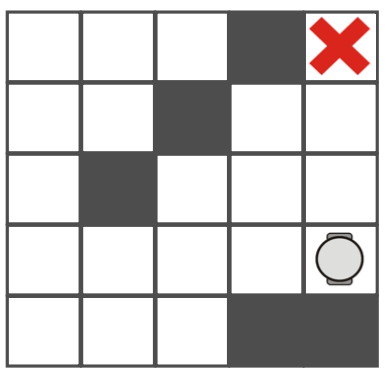

The environment is a simplification of a real robotic navigation problem.
A robot must find the shortest path to a target (red mark X), avoiding obstacles (gray squares).

The robot's position varies on a $5 \times 5$ grid, with the state $x \in \{0, ..., 19\}$ (the set of reachable states, that do not include the 5 obstacles).
Note that the state $x=0$ represents the top-left corner in the figure.

The robot can move one cell at a time in one of the four cardinal directions.
These four actions $u$ are represented by the numbers 0 (up), 1 (right), 2 (down), 3 (left).
Any movement that results in hitting a wall or obstacle fails, and the robot remains in the same cell.

The robot receives a reward of $-0.1$ at each step in which it does not reach the target, and $10$ when it reaches the target.

The target is a terminal state, so when it is reached, the episode ends, and the robot is reset to an initial position.
The negative reward represents energy consumption and leads to a minimum-time solution, i.e., a path of minimal length.

#### From MDP to simulation

An `MDP` object can be used by the `Sim` class to create an environment with a simple API that facilitates the agent-environment interaction loop:

- `x, done = sim.reset()` returns the initial state and the episode termination signal. Use it to begin a new episode. `done` indicates the agent reached the goal.
- `x', r, done = sim.step(u)` receives action `u` and returns the next state, reward and episode termination signal.

In [ ]:
# you can use the MDP you defined in the previous lab
GRIDNAV = """
G:10.0
x:0.0
.:-0.1
---
xxxxxxxxxxxx
xs    x    x
x xxx x xx x
x x   x xx x
x x x x    x
x   xGx xx x
x x x  x x x
x x xx    xx
x x     x  x
x xxx x xxxx
x     x    x
xxxxxxxxxxxx
"""

**Example**

You can see below how the simulation can be initialized from an `MDP` based on the `GRIDNAV` description and how it can be used.

In this example we are manualy directing the robot towards the goal `G`.

In [ ]:
sim = Sim(MDP(GRIDNAV))

print(sim.reset())
for i in range(8):
    if i == 2 or i > 4:
        print("x: {:2d}, r: {}, done: {}".format(*sim.step(0)))
    else:
        print("x: {:2d}, r: {}, done: {}".format(*sim.step(1)))

(46, False)
x: 47, r: -0.1, done: False
x: 48, r: -0.1, done: False
x: 40, r: -0.1, done: False
x: 41, r: -0.1, done: False
x: 42, r: -0.1, done: False
x: 36, r: -0.1, done: False
x: 36, r: 0.0, done: False
x: 36, r: 0.0, done: False


In [ ]:
# You can still access the mdp object within the simulation using `sim.mdp`.
sim.mdp
sim.mdp.nU
test=th.zeros(4,5,2)
test
test[1,2,1]=1
test[1,2].argmax()
#sim.mdp.U
test[1,2]



tensor([0., 1.])

### Task 1.1 [4pts]
---

Implement Q-Learning with $\varepsilon$-greedy exploration.
The algorithms has to run for a given number of trajectories (or trials), $T$.
Each trajectory ends when the agent reaches a terminal state or after a maximum number of steps, $K$.
This second condition is for making sure the episode terminates in a reasonable amount of time.

The signature of the function is given below.

**Arguments:**

- the `Sim` object
- learning rate `α`
- exploration probability `ε`
- discount factor `γ`
- the number of trials `T`
- the maximum number of steps per trial `K`

**Returns:**
- $Q_\text{trials}$, a `torch` matrix of shape $T \times X \times U$ containing the Q-values for every state-action pair at the end of each trial.
- $R(x_0)_\text{trials}$, a `torch` vector of size $T$ containing the _discounted_ returns of each trial (trajectory).

In [ ]:
def q_learning(sim, α=0.1, ε=0.3, γ=0.9, T=100, K=500):
  Q=th.zeros(T,sim.mdp.nX,sim.mdp.nU)
  R=th.zeros(T)
  actions=sim.mdp.U
  for t in range(T):
    x, done=sim.reset()
    if t!=0:
      Q_prevTrial=Q[t-1].clone()
      Q[t]=Q_prevTrial
    for k in range(K):
      if rnd.random()<(1-ε):
        u=Q[t,x].argmax().item()
      else:
        u=rnd.choice(actions)
      xp, r, done=sim.step(u)
      Q[t,x,u]=Q[t,x,u]+ α*(r+γ*Q[t,xp].max().item()-Q[t,x,u])

      R[t]+=γ**(k)*r
      if done:
        break
      else:
        x=xp
  Q_trials= Q
  R_trials= R
  return Q_trials, R_trials

In [ ]:
#Computin the discounted rewards after each trial, not at each step
def q_learning2(sim, α=0.1, ε=0.3, γ=0.9, T=100, K=500):
  Q=th.zeros(T,sim.mdp.nX,sim.mdp.nU)
  R=th.zeros(T)
  actions=sim.mdp.U
  for t in range(T):
    x, done=sim.reset()
    rewards=[]
    if t!=0:
      Q_prevTrial=Q[t-1].clone()
      Q[t]=Q_prevTrial
    for k in range(K):
      if rnd.random()<(1-ε):
        u=Q[t,x].argmax().item()
      else:
        u=rnd.choice(actions)
      xp, r, done=sim.step(u)
      Q[t,x,u]=Q[t,x,u]+ α*(r+γ*Q[t,xp].max().item()-Q[t,x,u])
      rewards.append(r)
      if done:
        break
      else:
        x=xp
    discount=1
    for reward in rewards:
      R[t]+=reward*discount
      discount*=γ
  Q_trials= Q
  R_trials= R
  return Q_trials, R_trials

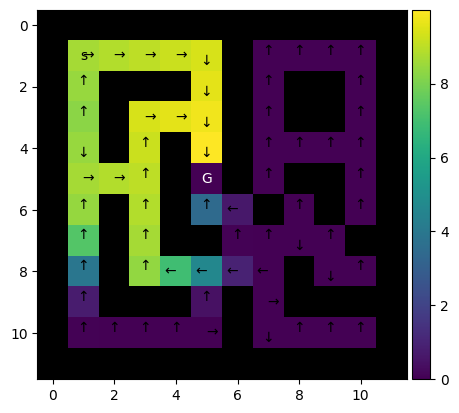

In [ ]:
sim = Sim(MDP(GRIDNAV))
Q_trials, R_trials = q_learning(sim, γ=0.99, α=0.1, ε=0.9, K=500, T=300)

Q = Q_trials[-1]
h = th.eye(sim.mdp.nU)[Q.argmax(1)]

MDP.plot_policy(sim.mdp, h, Q.max(1).values)

### Task 1.2 [1pt]

Evaluate Q-learning on your own `GRIDNAV` problem.
**Show that your implementation works by evaluating it with $\gamma \in [0.7, 0.99]$.**

Suggested values for the hyperparameters with which you can start experimenting are in the function call bellow.

Plot the final Q-values, as well as the resulting policies for various $\gamma$ values.

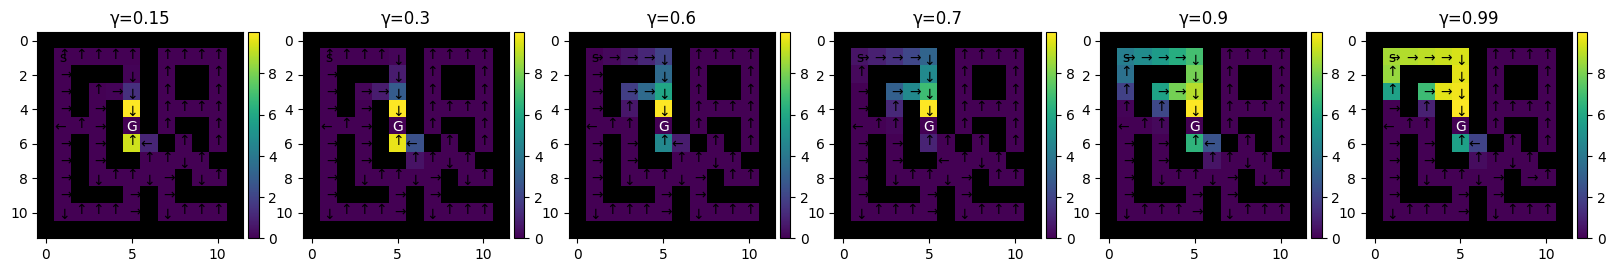

In [ ]:
sim = Sim(MDP(GRIDNAV))

fig, axs = plt.subplots(1, 6, figsize=(20,20))
for ax, γ in zip(axs, [0.15, 0.3, 0.6, 0.7, 0.9, 0.99]):
    Q_trials, R_trials = q_learning(sim, γ=γ, α=0.1, ε=0.5, K=500, T=300)

    Q = Q_trials[-1]
    h = th.eye(sim.mdp.nU)[Q.argmax(1)]

    MDP.plot_policy(sim.mdp, h, Q.max(1).values,ax=ax)

    ax.set_title(f"γ={γ}")

### Task 1.3 [1pt]


Change the definition of your `GRIDNAV` environment to experiment with different starting positions.

In [ ]:
GRIDNAV = """
G:10.0
x:0.0
.:-0.1
---
xxxxxxxxxxxx
x     x    x
x xxx x xx x
x x   x xx x
x x x x    x
x   xGx xx x
x x x  x x x
x x xx    xx
x x     x  x
x xxx x xxxx
x     x   sx
xxxxxxxxxxxx
"""

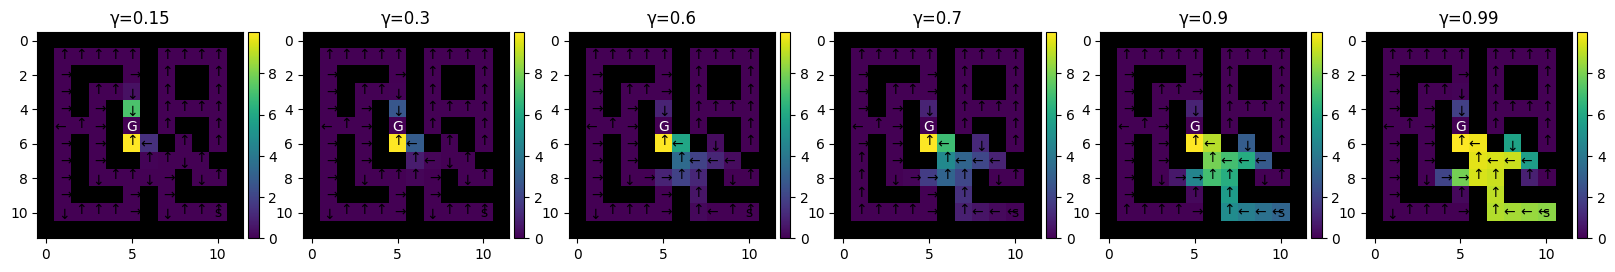

In [ ]:
sim = Sim(MDP(GRIDNAV))

fig, axs = plt.subplots(1, 6, figsize=(20,20))
for ax, γ in zip(axs, [0.15, 0.3, 0.6, 0.7, 0.9, 0.99]):
    Q_trials, R_trials = q_learning(sim, γ=γ, α=0.1, ε=0.5, K=500, T=300)

    Q = Q_trials[-1]
    h = th.eye(sim.mdp.nU)[Q.argmax(1)]

    MDP.plot_policy(sim.mdp, h, Q.max(1).values,ax=ax)

    ax.set_title(f"γ={γ}")

**Question:**

What are some advantages and disadvantages of starting in initial states that are close to the goal? It may help you to consider a problem where there are several goals with different rewards, like ROOMBA.

**Your answer:**

The main advantage of starting closer to the goal is that the agent doesn't need to explore the environment too much untill finding the goal and the algorithm will converge rapidly and we can obtain an optimal policy (not $h^*$ which is the optimal policy for the entire grid, but a $\hat{h}$ which is a local optimal policy considering a given starting point). To put this short, starting closer to the goal will make the agent find the goal faster without having to try too many trajectories.

In what concerns the disadvantages of starting closer to a goal is that the agent will not explore enough the environment and so, the resulted $Q$-value and, subsequently, the resulted policy will be far from the optimal $Q^*$-value, respectively policy $h^*$. Another disadvantage is that, the agent will reach a certain goal without exploring too much which can cause it to miss other possible goals with a greater reward, that can generate a $Q$-value closer to the optimal one.

This can be summed up by saying that the agent's success becomes overly reliant on the starting point.

## Part 2

Implement an exponential exploration schedule that starts at a high value $\varepsilon=1$ and degrades towards $0$ with each _trial_.
The value of $\varepsilon$ is constant during a trial and gets updated according to $\varepsilon \gets \varepsilon * d$ at the end of the trial, where $d$ is the decay rate. Experiment with $d \in [0.9, 0.99]$.

Use $T=100, \alpha=0.1, \gamma=0.98$ and keep them constant for different values of $d$. For **each value of $d$** you will have to generate two plots:

### Task 2.1 [1pt]

Plot the distances between $Q^\ast$ and $Q_t$, the $Q$ values found at the end of each trial.

Plot the trial number on the horizontal axis `ox` and the distance between $Q$ functions on the vertical axis `oy`.

Use a norm of your choosing to compare the distances between $Q^\ast$ and each $Q_t$ and `matplotlib.pyplot.plot` for plotting.

You can find here a [short matplotlib tutorial on lineplots](https://matplotlib.org/stable/users/explain/quick_start.html#coding-styles).

**Important:** For computing $Q^\ast$ use one of the algorithms you implemented in `lab1` and the `MDP` class.

In [ ]:
def q_learning_expDecay(sim, α=0.1, d=0.9, γ=0.9, T=100, K=500):
  ε=1
  Q=th.zeros(T,sim.mdp.nX,sim.mdp.nU)
  R=th.zeros(T)
  actions=sim.mdp.U
  for t in range(T):
    x, done=sim.reset()
    if t!=0:
      Q_prevTrial=Q[t-1].clone()
      Q[t]=Q_prevTrial
    for k in range(K):
      if rnd.random()<(1-ε):
        u=Q[t,x].argmax().item()
      else:
        u=rnd.choice(actions)
      xp, r, done=sim.step(u)
      Q[t,x,u]=Q[t,x,u]+ α*(r+γ*Q[t,xp].max().item()-Q[t,x,u])

      R[t]+=γ**(k)*r
      if done:
        break
      else:
        x=xp
    ε*=d
  Q_trials= Q
  R_trials= R
  return Q_trials, R_trials

In [ ]:
def get_q_star(mdp, γ, ε_iter=1e-1):
  # TODO: compute Q_star (hint: you can use one of the algorithms you already learned)
  Q = th.zeros((mdp.nX, mdp.nU))
  Q_prev=Q.clone()
  q_itt=0
  while True:
    q_itt+=1
    Q_prev=Q.clone()
    for x in mdp.X:
      for u in mdp.U:
        x_next, r=mdp.f(x, u), mdp.rho(x, u)
        Q[x,u]=r+γ*Q_prev[x_next,:].max().item()
    if th.norm(Q-Q_prev)<=ε_iter:
      break
  h=th.zeros(mdp.nX,mdp.nU)
  for x in mdp.X:
    Q_max=Q[x,:].argmax()
    h[x,Q_max]=1
  return Q, h

In [ ]:
sim = Sim(MDP(GRIDNAV))

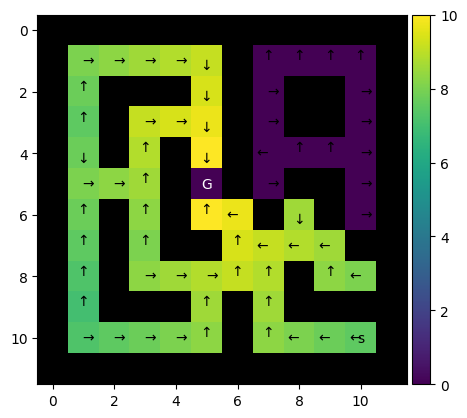

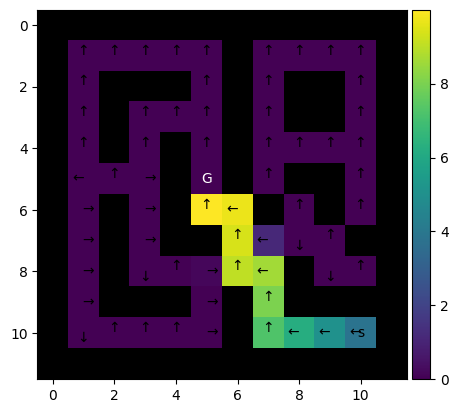

In [ ]:
Q_star, h = get_q_star(sim.mdp, 0.98)
MDP.plot_policy(sim.mdp, h, Q_star.max(1).values)

Q_trials, R_trials = q_learning_expDecay(sim, α=0.1,d=0.94, γ=0.98, T=100, K=500)
Q = Q_trials[-1]
h = th.eye(sim.mdp.nU)[Q.argmax(1)]
MDP.plot_policy(sim.mdp, h, Q.max(1).values)

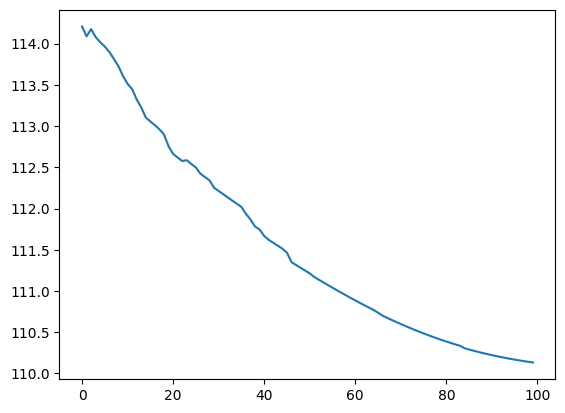

In [ ]:
Q_distance=[]
i=0
for Q in Q_trials:
  Q_distance.append(th.norm(Q-Q_star).item())
plt.plot(Q_distance)

### Task 2.2 [1pt]

Plot the return $R(x_0)$ obtained by your algorithm for each trial (trajectory). Plot the trial number on `ox` and the return on `oy`.

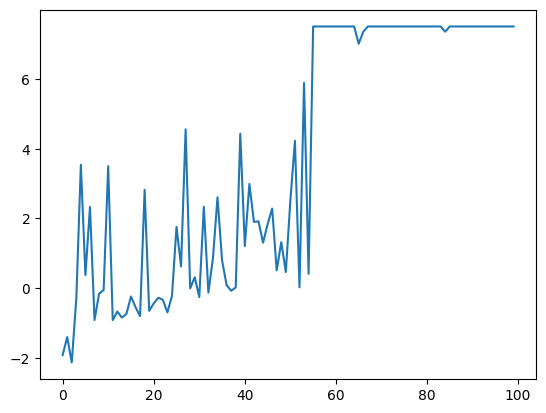

In [ ]:
plt.plot(R_trials)


### Task 2.3 [2pts]
---

Discuss which decay rate $d$ works better for obtaining a high precision of the Q function, a large return $R(x_0)$ and for a reasonable trade-off between the two. Explain the relation between the two plots and the reasons of this trade-off.

**Your answer:**

In this case, the optimal performance is achieved with a decay rate of $d$=0.94

From the graphs below, we observe the following: as the decay rate increases (i.e. the algorithm continues exploring for longer, even after running many trajectories and converging to a local optimal $Q$-value), the distance to the optimal $Q^*$-value gradually decreases. With a smaller decay rate, the agent converges more quickly to a local optimal $Q$-value. However, if we consider the evolution of the return $R$, we notice that a smaller decay rate leads to rapid reduction in the agent's probability to explore. This causes the agent to prematurely focus on exploiting previously learned actions that maximize the $Q$-value, often resulting in a return close to zero — an undesirable outcome.

On the other hand, when the decay rate is too close to 1, the agent continues exploring excessively even after discovering a local optimum $Q$-value. This delays exploitation of the learned policy, as reflected in the return $R$: even after many trajectories, the return does not stabilize to a consistent value. This behavior is particularly evident for decay rates $d$=0.98 and $d$=0.99.

Thus, a trade-off is crucial when selecting the decay rate for the exploration parameter ɛ. The goal is to ensure that the agent explores sufficiently during the early stages of learning but transitions to exploitation at the right time as it gains knowledge from previously explored trajectories.

In this case, the decay rate $d$=0.94 achieves this balance. The agent reduces exploration after approximately 60 trajectories, shifting toward exploitation. As a result, the reward $R$ stabilizes more quickly, leading to a desirable learning outcome.

**The discussion presented above is sustained by the plots represented bellow**

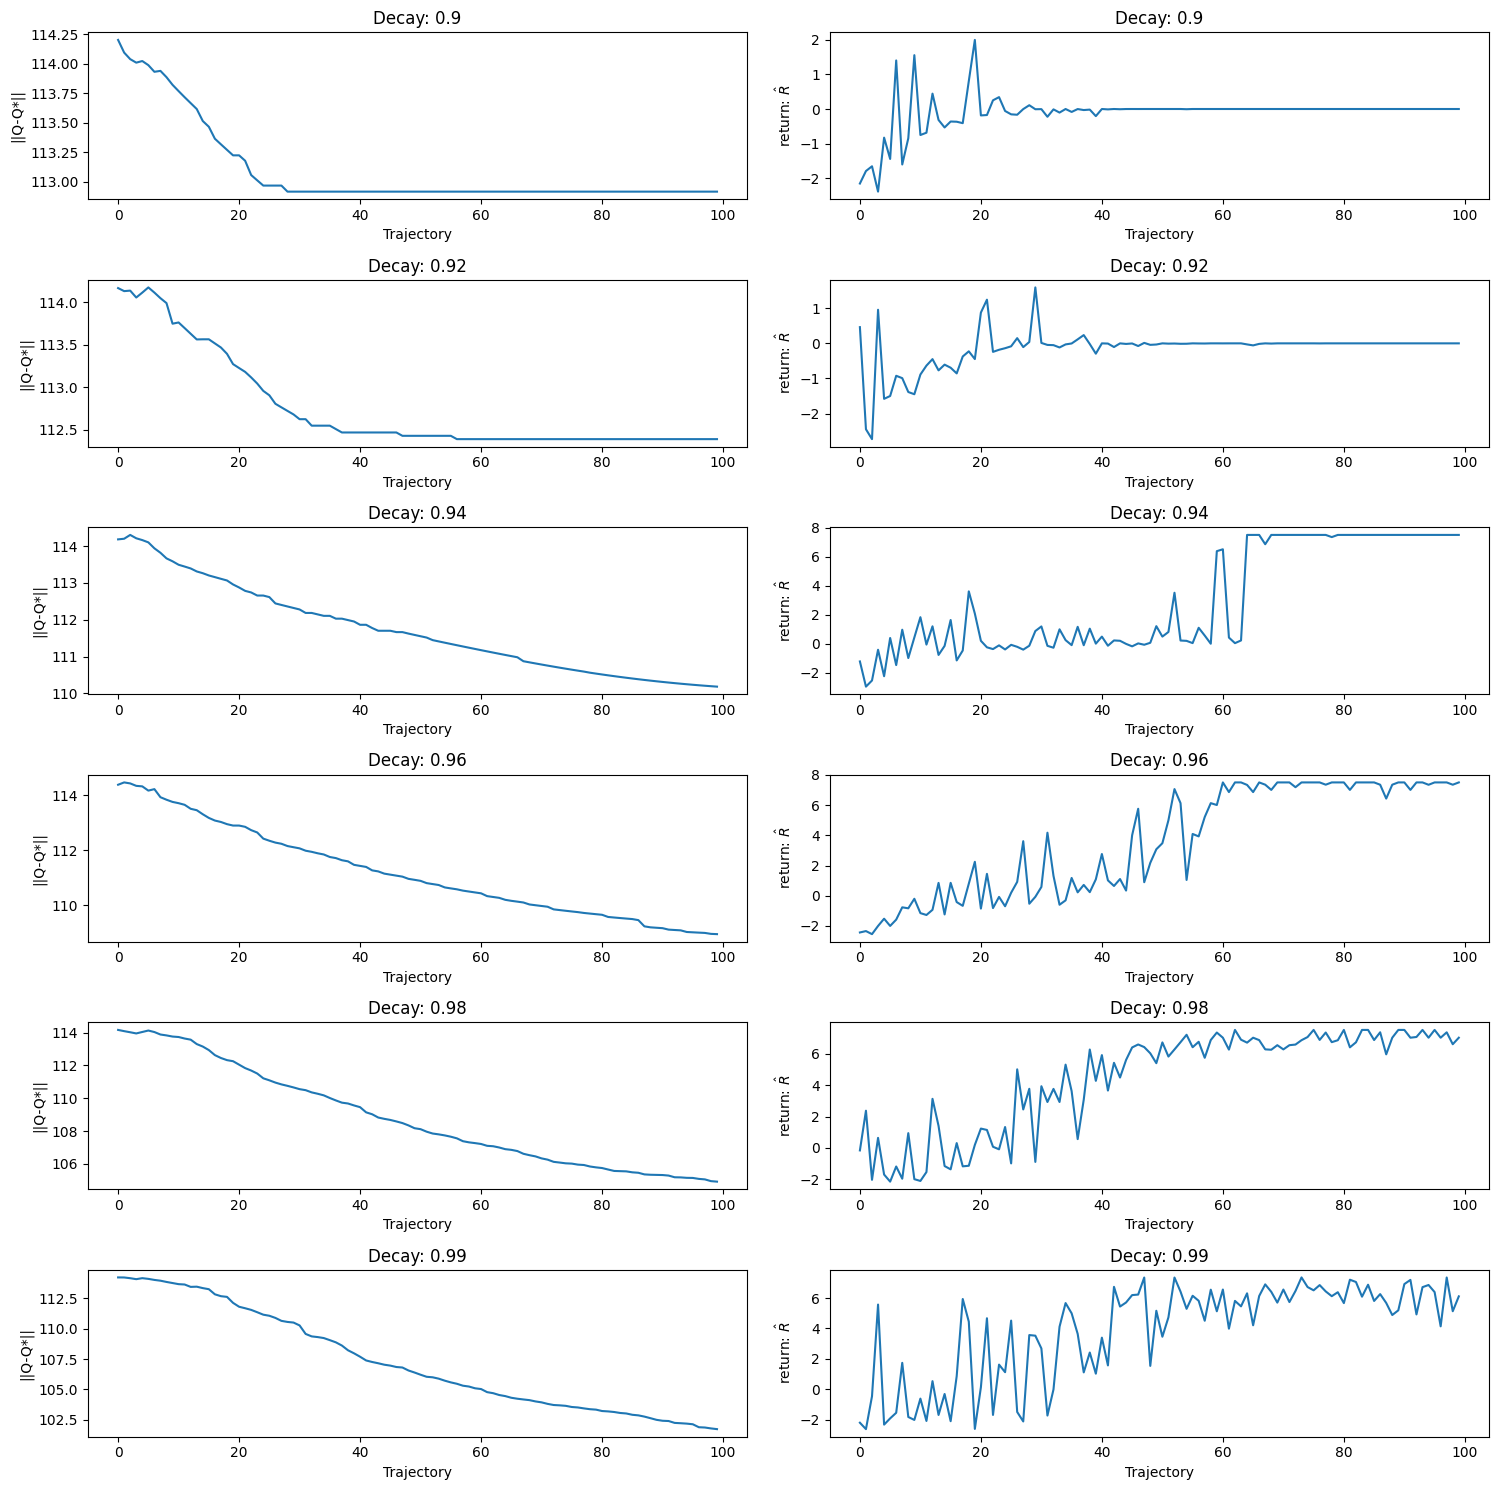

In [ ]:
sim = Sim(MDP(GRIDNAV))

Q_star, h = get_q_star(sim.mdp, 0.98)


fig, axs = plt.subplots(6, 2, figsize=(15,15))
for ax, d in zip(axs, [0.9, 0.92, 0.94, 0.96, 0.98, 0.99]):
    Q_trials, R_trials = q_learning_expDecay(sim, α=0.1,d=d, γ=0.98, T=100, K=500)
    Q_distance=[]
    for Q in Q_trials:
      Q_distance.append(th.norm(Q-Q_star).item())

    ax[0].set_title(f"Decay: {d}")
    ax[0].set_xlabel("Trajectory")
    ax[0].set_ylabel("||Q-Q*||")
    ax[0].plot(Q_distance)

    ax[1].set_title(f"Decay: {d}")
    ax[1].set_xlabel("Trajectory")
    ax[1].set_ylabel("return: $\hat{R}$")
    ax[1].plot(R_trials)

plt.tight_layout()
plt.show()
